# Test association with behavioural variable such as reaction time
This notebook runs permutation tests to see whether there is a statistically significant relationship between the phase angle at which a target stimulus was presented and the response was given by the participant. The analysis is done for each participant separately, and the results are visualised in polar plots.


In [1]:
import pickle
import numpy as np
from pathlib import Path
from pyriodic.permutation import permutation_test_phase_modulation
from pyriodic.viz import CircPlot
from pyriodic import Circular
import matplotlib.pyplot as plt


In [2]:
# defining some constants
num_bins = 6  
stat = "median"
filter_outliers = True

subj_ids = ["0001", "0002", "0003", "0012", "0013", "0014", "0016", "0018", "0019", 
            "0020", "0021", "0022", "0023", "0024", "0026", "0027", "0028", "0029", 
            "0030", "0031"]
data_path = Path("../../data/respiration/intermediate")
sfreq = 300  # Hz



## Single level analysis for all participants

In [ ]:
# defining some helper functions
def binned_stats(phase_angles, var, n_bins=10, stat="mean"):
    """
    Calculate binned statistics for response times.
    
    Parameters:
    rt (array-like): Response times.
    n_bins (int): Number of bins to use.
    stat (str): Statistic to calculate ('mean' or 'median').
    
    Returns:
    bin_centers (array): Centers of the bins.
    avg_response_times (array): Average response times in each bin.
    std_response_times (array): Standard deviation of response times in each bin.
    """
    bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    avg_response_times = np.zeros(n_bins+1)
    std_response_times = np.zeros(n_bins+1)
    
    for i in range(n_bins):
        bin_mask = (phase_angles >= bin_edges[i]) & (phase_angles < bin_edges[i + 1])
        if stat == "mean":
            avg_response_times[i] = np.mean(var[bin_mask]) if np.any(bin_mask) else np.nan
        elif stat == "median":
            avg_response_times[i] = np.median(var[bin_mask]) if np.any(bin_mask) else np.nan
        else:
            raise ValueError("stat must be 'mean' or 'median'")
        # Ensure the last two dots are connected
        std_response_times[i] = np.std(var[bin_mask]) if np.any(bin_mask) else np.nan
            
    # Ensure the last two dots are connected
    avg_response_times[-1] = avg_response_times[0]
    std_response_times[-1] = std_response_times[0]
    bin_centers = np.concatenate((bin_centers, [bin_centers[0]]))

    return bin_centers, avg_response_times, std_response_times




### Association between reaction time and phase angle at the time of target presentation

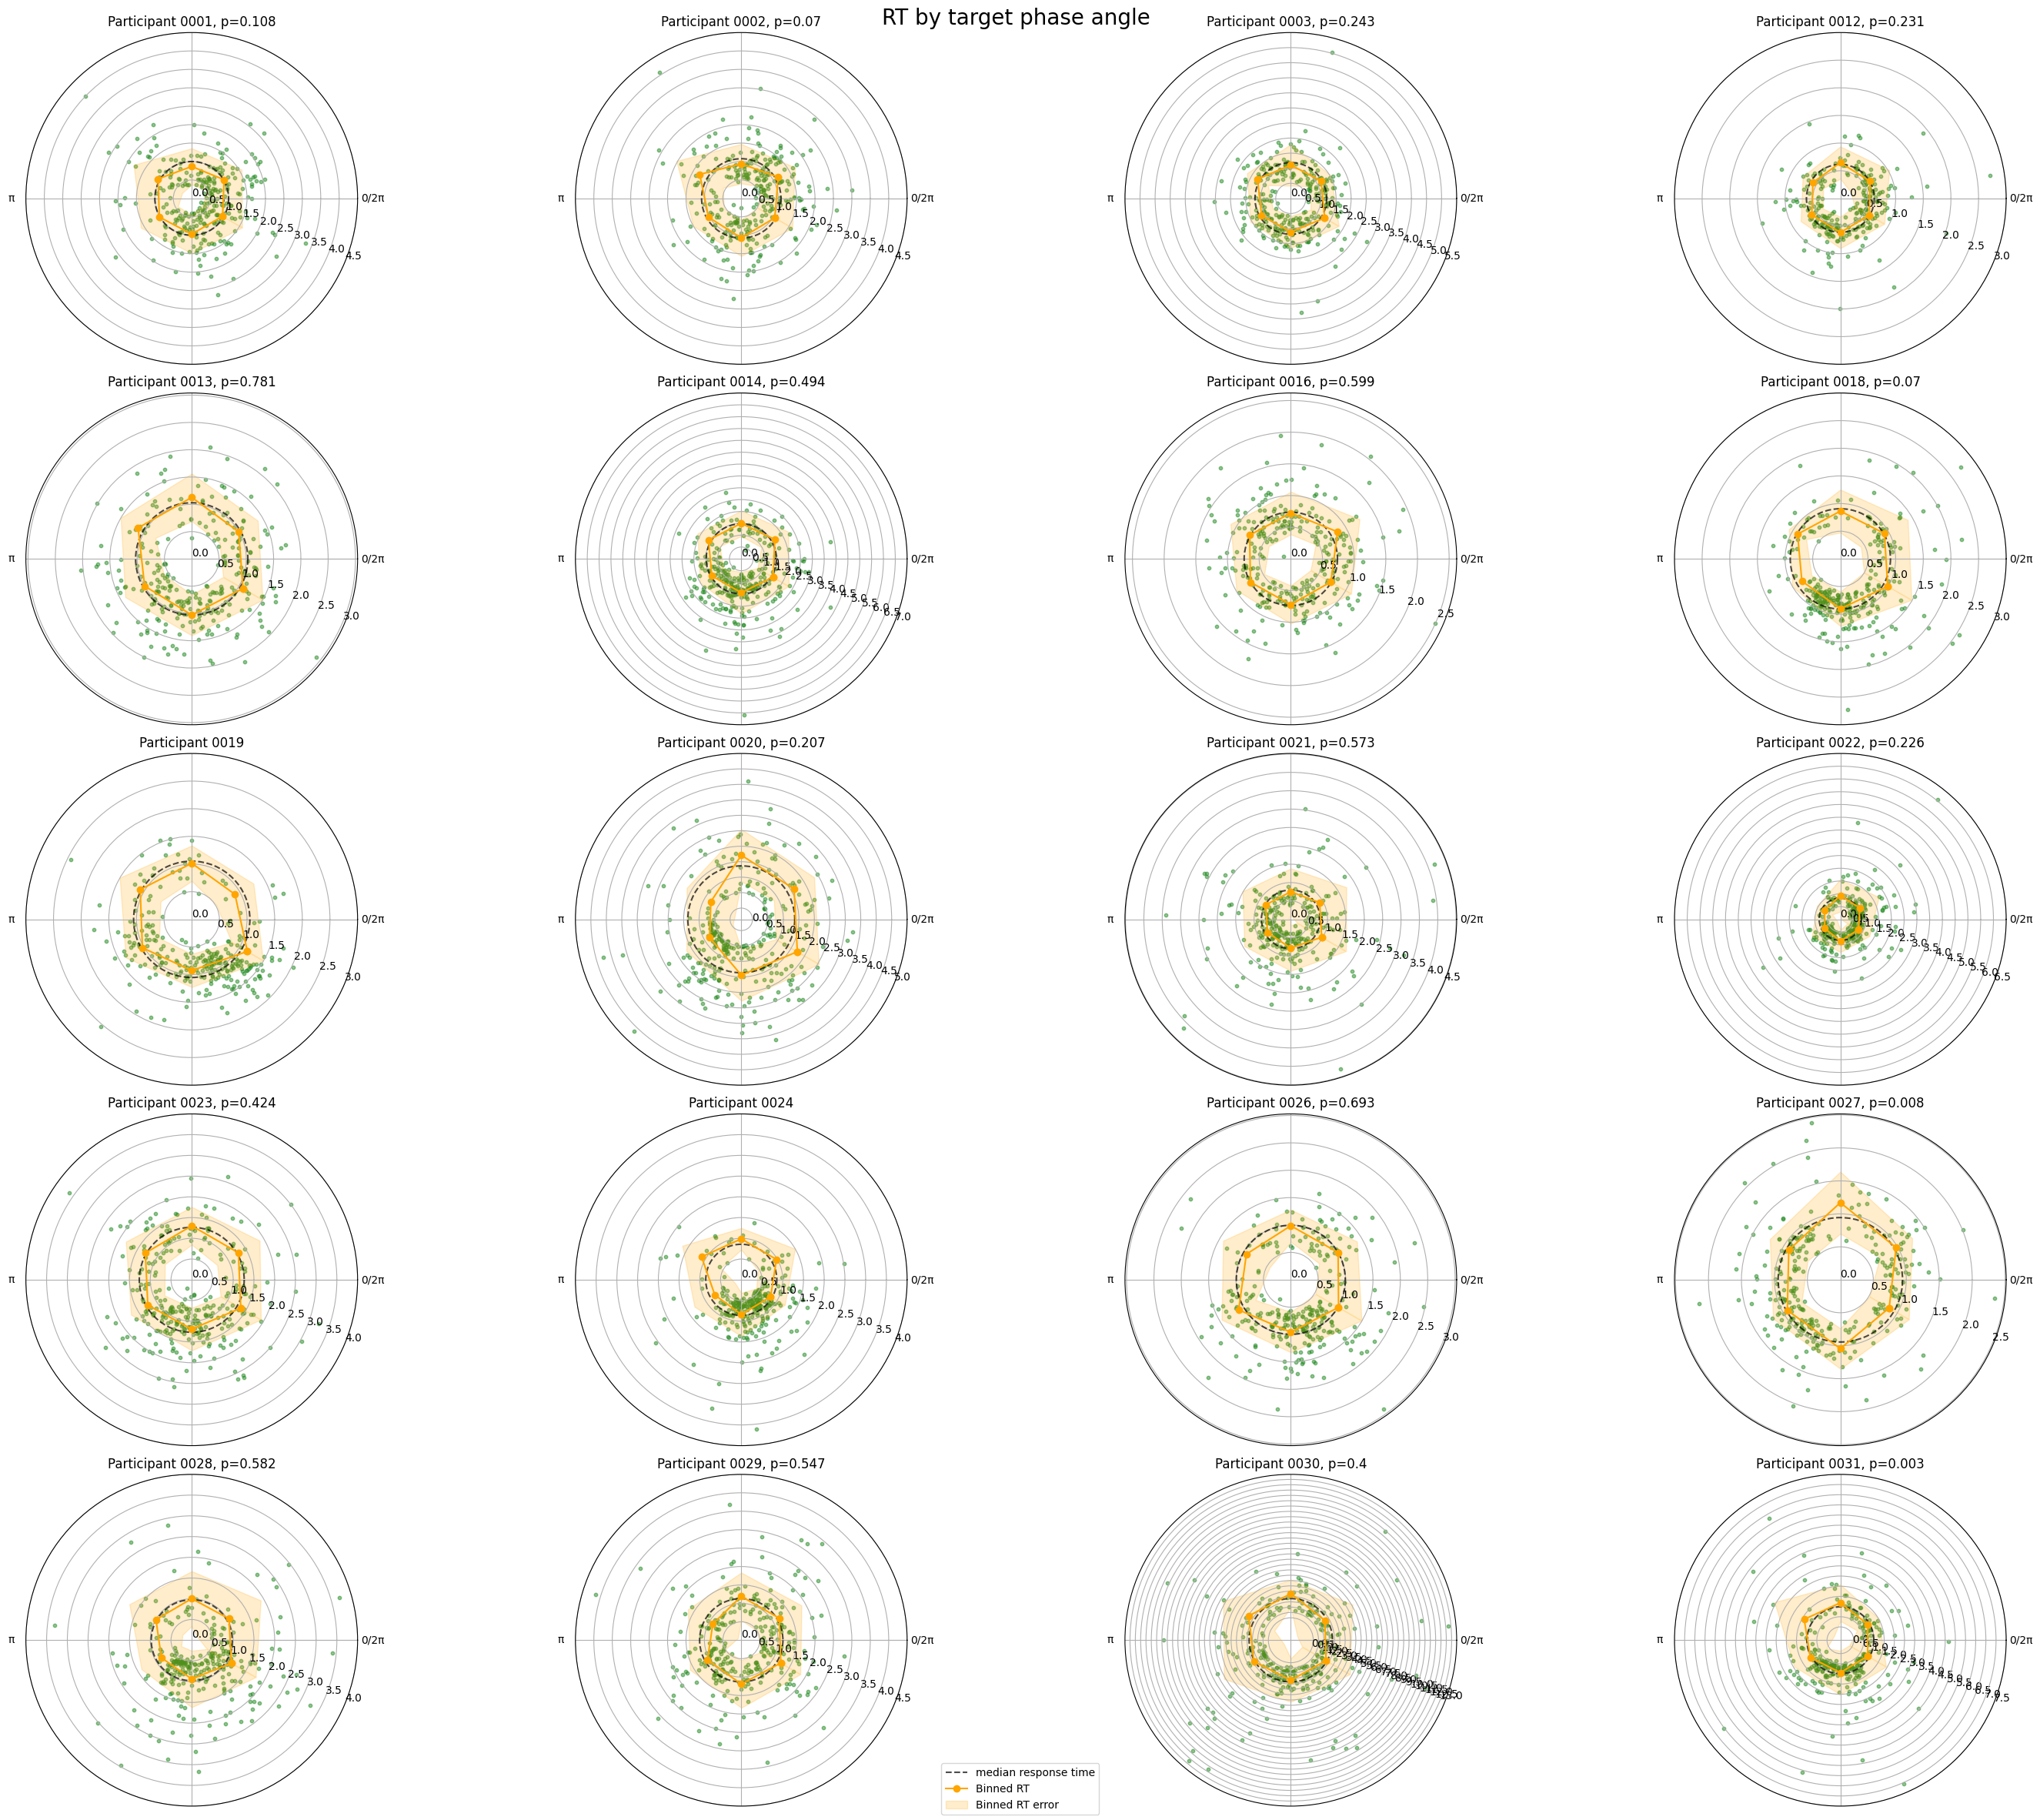

In [4]:
n_rows = len(subj_ids) // 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows * 6, n_cols * 6), subplot_kw={"projection": "polar"})

for subj_id, ax in zip(subj_ids, axes.flatten()):

    file_path = data_path / f"participant_{subj_id}_preproc.pkl"

    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    circ = data["circ"]
    rejected_indices = np.array(data["rejected_indices"])
    event_samples = data["event_samples"]
    event_samples = event_samples[~np.isin(event_samples, rejected_indices)]
    labels = circ.labels

    # FIND ALL THE TARGET EVENTS AND CALCULATE THEIR RESPONSE TIMES BY THE EVENT SAMPLES
    response_times = []
    idx_target = [i for i, label in enumerate(labels) if "target" in label]

    for idx in idx_target:
        target_sample = event_samples[idx]
        # Check that the label of the next event is "response"
        if "response" not in labels[idx + 1]:
            response_times.append(np.nan)
            continue
        response_sample = event_samples[idx + 1]
        resp_time = (response_sample - target_sample) / sfreq  # convert to seconds
        response_times.append(resp_time)

    targets = circ["target"].data
    targets = targets[~np.isnan(response_times)]
    response_times = np.array(response_times)[~np.isnan(response_times)]

    if filter_outliers:
        # Filter out outliers by standard deviation
        upper_bound = np.mean(response_times) + 5 * np.std(response_times)
        lower_bound = np.mean(response_times) - 5 * np.std(response_times)

        # Filter out outliers
        filtered_indices = np.where((response_times >= lower_bound) & (response_times <= upper_bound))
        targets = targets[filtered_indices]
        response_times = response_times[filtered_indices]

    
    # PERFORM PERMUTATION TEST ON THE DATA
    try:
        obs, p = permutation_test_phase_modulation(
            targets, response_times, n_null=1000, verbose=False, n_bins=num_bins
        )
    except ValueError:
        obs, p = None, None
    
    # PLOTTING
    circ_tmp = Circular(targets)
    plot = CircPlot(circ_tmp, ax=ax, group_by_labels=False)
    plot.add_points(
        y=response_times, 
        s=10, 
        alpha=0.5, 
        marker='o', 
        color="forestgreen",
        label=None
    )

    plot.add_hline(
        y=np.mean(response_times) if stat == "mean" else np.median(response_times),
        label=f"{stat} response time",
        color="black",
        alpha=0.7,
        linestyle="--"
    )

    # AVERAGE RESPONSE TIME IN BINS + STD
    bin_centers, avg_response_times, std_response_times = binned_stats(circ_tmp.data, response_times, n_bins=num_bins, stat=stat)


    plot.add_polar_line(
        angles=bin_centers,
        values=avg_response_times,
        errors=std_response_times,
        color='orange',
        label='Binned RT',
        marker='o',
        linestyle='-'
    )
    # Customize the plot
    ax.set_yticks(np.arange(0, np.max(response_times) + 0.5, 0.5))
    ax.set_yticklabels([f"{i:.1f}" for i in np.arange(0, np.max(response_times) + 0.5, 0.5)])

    try:
        ax.set_title(f"Participant {subj_id}, p={p.round(3)}", fontsize=12)
    except AttributeError:
        ax.set_title(f"Participant {subj_id}", fontsize=12)


    ax.yaxis.grid(True)

# Add a single legend for the entire figure at the top center
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle("RT by target phase angle", fontsize=20)

plt.tight_layout()
plt.show()


### Association between reaction time and phase angle at the time of response

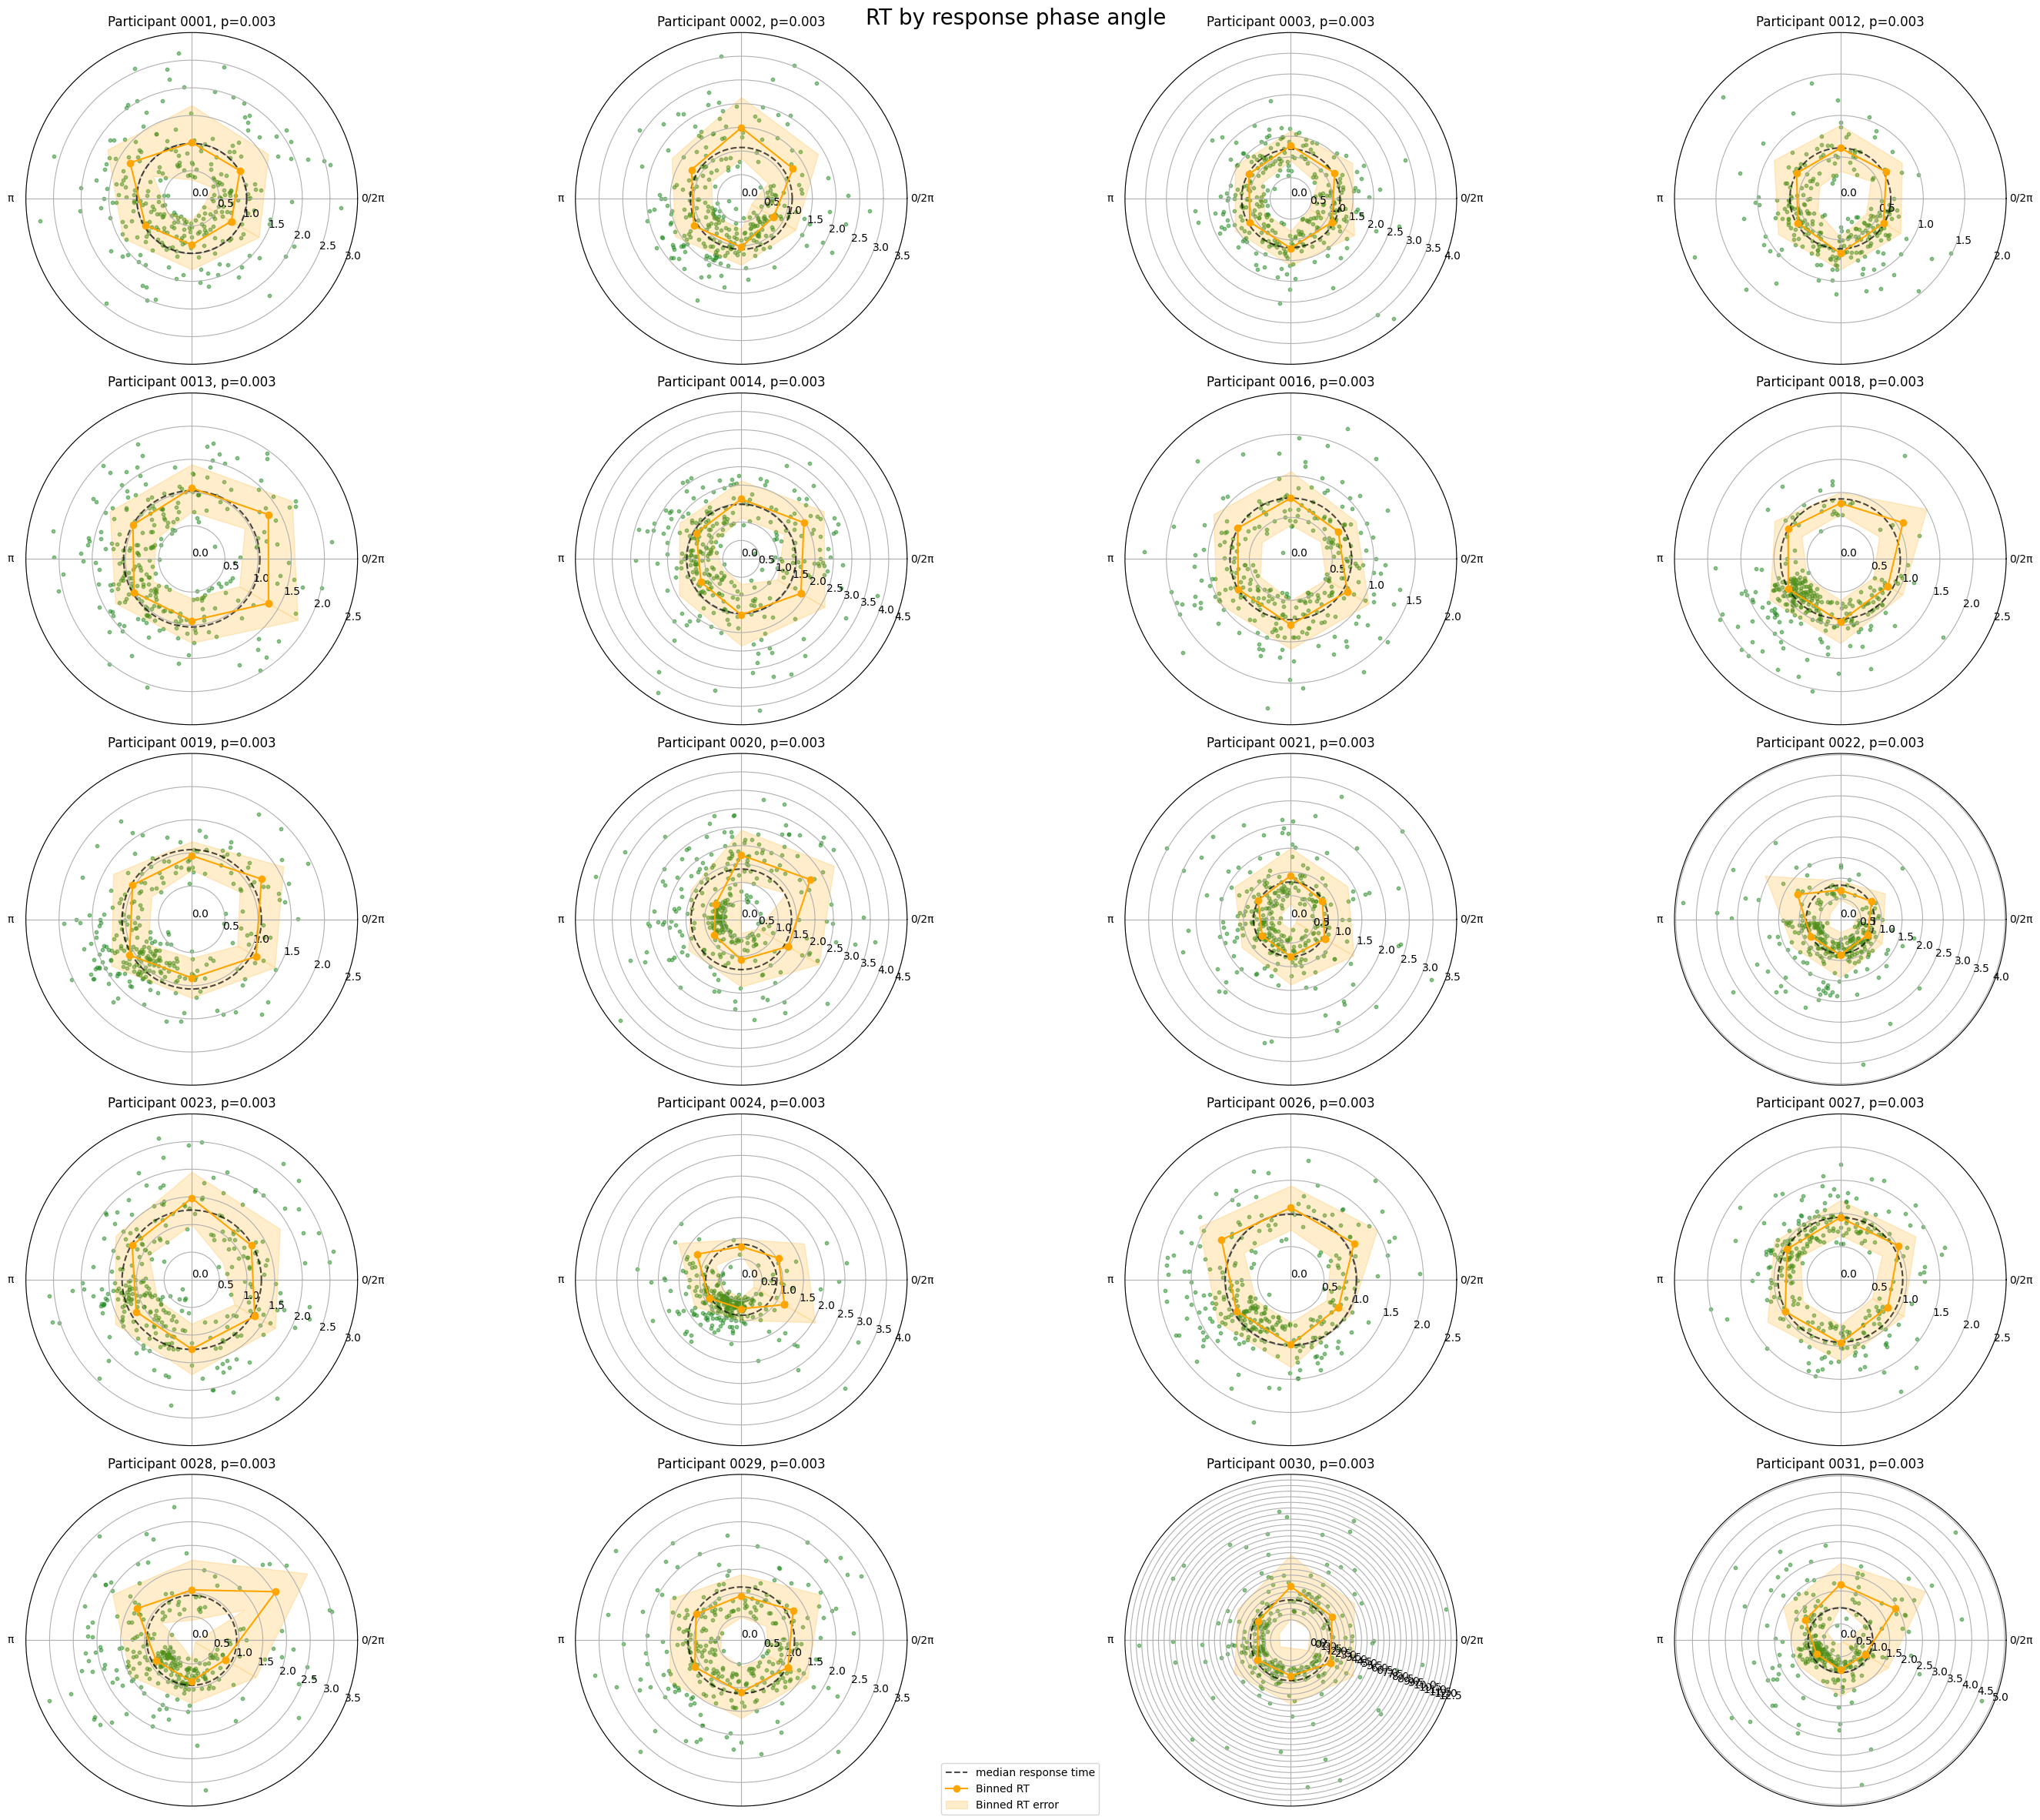

In [5]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows * 6, n_cols * 6), subplot_kw={"projection": "polar"})

for subj_id, ax in zip(subj_ids, axes.flatten()):

    file_path = data_path / f"participant_{subj_id}_preproc.pkl"

    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    circ = data["circ"]
    rejected_indices = np.array(data["rejected_indices"])
    event_samples = data["event_samples"]
    event_samples = event_samples[~np.isin(event_samples, rejected_indices)]
    labels = circ.labels

    # FIND ALL THE TARGET EVENTS AND CALCULATE THEIR RESPONSE TIMES BY THE EVENT SAMPLES
    idx_target = [i for i, label in enumerate(labels) if "target" in label]
    response_phase_angles = []
    response_times = []
    
    for idx in idx_target:
        target_sample = event_samples[idx]
        # Check that the label of the next event is "response"
        if "response" not in labels[idx + 1]:
            continue
        response_sample = event_samples[idx + 1]
        resp_time = (response_sample - target_sample) / sfreq  # convert to seconds
        response_times.append(resp_time)
        response_phase_angles.append(circ.data[idx + 1])


    response_times = np.array(response_times)
    response_phase_angles = np.array(response_phase_angles)
    if filter_outliers:
        # Filter out outliers by standard deviation
        upper_bound = np.mean(response_times) + 3 * np.std(response_times)
        lower_bound = np.mean(response_times) - 3 * np.std(response_times)

        # Filter out outliers
        filtered_indices = np.where((response_times >= lower_bound) & (response_times <= upper_bound))
        response_phase_angles = response_phase_angles[filtered_indices]
        response_times = response_times[filtered_indices]
   

    # PLOTTING
    circ_tmp = Circular(response_phase_angles)
    plot = CircPlot(circ_tmp, ax=ax, group_by_labels=False)
    
    plot.add_points(
        y=response_times, 
        s=10, 
        alpha=0.5, 
        marker='o', 
        color="forestgreen",
        label=None
    )

    plot.add_hline(
        y=np.mean(response_times) if stat == "mean" else np.median(response_times),
        label=f"{stat} response time",
        color="black",
        alpha=0.7,
        linestyle="--"
    )

    # AVERAGE RESPONSE TIME IN BINS + STD
    bin_centers, avg_response_times, std_response_times = binned_stats(circ_tmp.data, response_times, n_bins=num_bins, stat=stat)


    plot.add_polar_line(
        angles=bin_centers,
        values=avg_response_times,
        errors=std_response_times,
        color='orange',
        label='Binned RT',
        marker='o',
        linestyle='-'
    )
    # Customize the plot
    ax.set_yticks(np.arange(0, np.max(response_times) + 0.5, 0.5))
    ax.set_yticklabels([f"{i:.1f}" for i in np.arange(0, np.max(response_times) + 0.5, 0.5)])

    try:
        ax.set_title(f"Participant {subj_id}, p={p.round(3)}", fontsize=12)
    except AttributeError:
        ax.set_title(f"Participant {subj_id}", fontsize=12)


    ax.yaxis.grid(True)

# Add a single legend for the entire figure at the top center
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')


fig.suptitle("RT by response phase angle", fontsize=20)
plt.tight_layout()
plt.show()
